Sampling rate: 48000 Hz
Carrier frequency: 12000 Hz
Bandwidth: 5000 Hz
Modulation sensitivity: 1.8318265833874044e-05


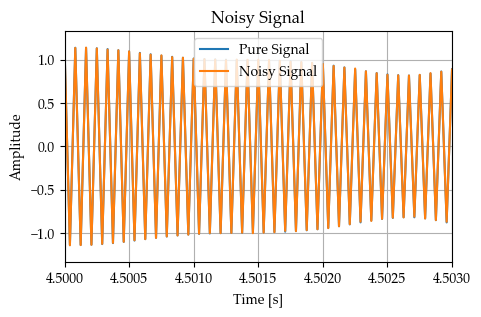

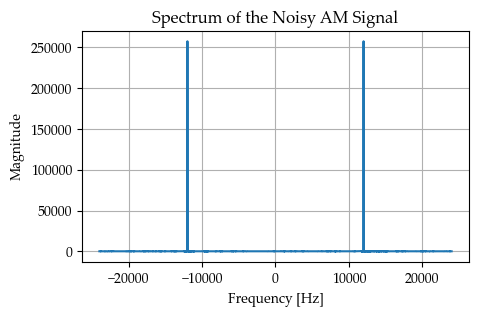

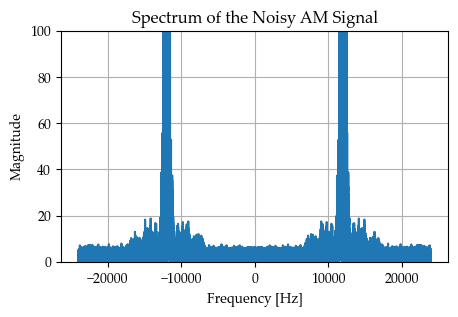

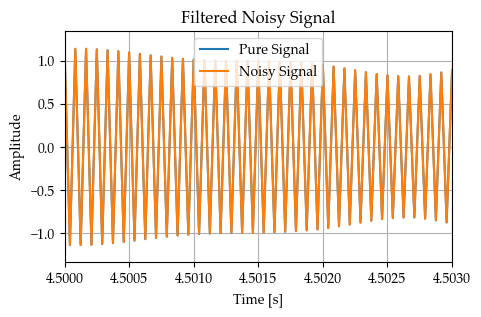

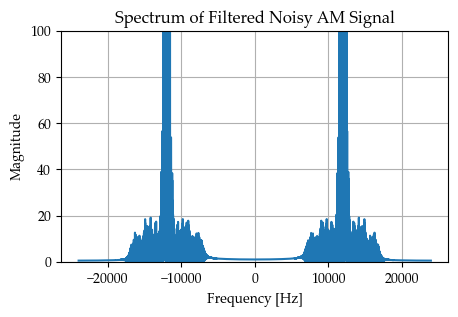

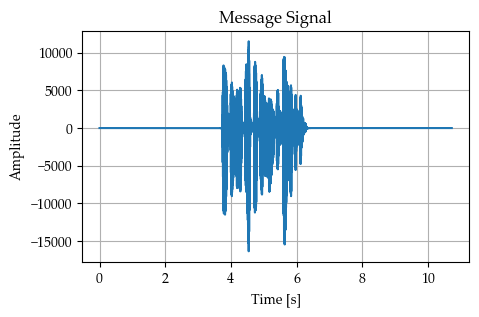

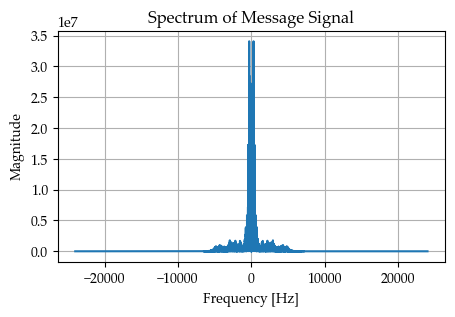

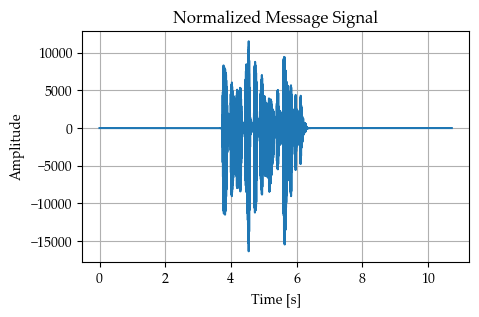

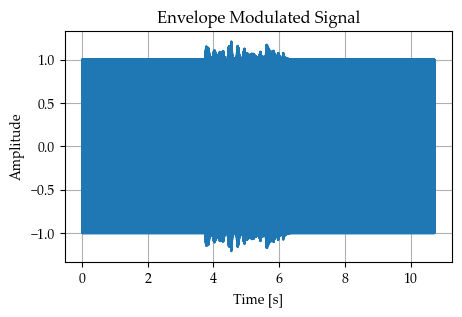

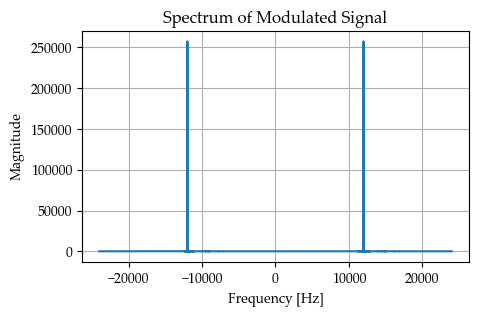

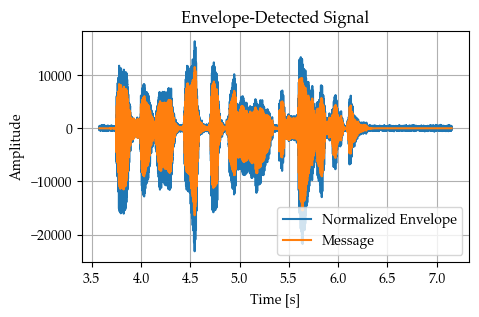

(46.99048047802081, 119.92856084273464)

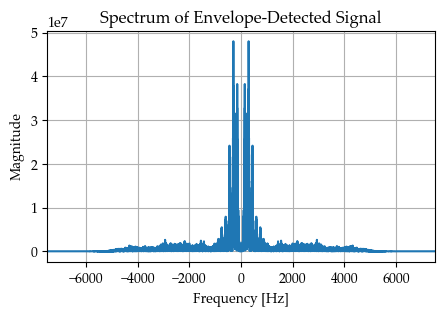

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft, fftshift
from scipy.io import wavfile

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['legend.loc'] = 'best'
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = [5,3]

mod_index = 0.3 # modulation index specified by the problem

def calculate_snr(signal, noise):
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    return 10 * np.log10(signal_power / noise_power)

# 1. Generate Sinusoidal Message Signal
fs, message = wavfile.read('audio.wav')
bw = 5000

b, a = butter(8, bw, fs=fs, btype='low', analog=False)
message_filtered = filtfilt(b, a, message)
ka = mod_index / np.max(np.abs(message_filtered))

audio_data = np.copy(message_filtered)
audio_data_length = len(message_filtered)
new_message = np.zeros(3*len(message_filtered)) #!! 补长信号，以补偿滤波器的误差
new_message[len(message_filtered):2*len(message_filtered)] = message_filtered
message = new_message
t = np.arange(0, len(message)/fs, 1/fs)
fc = 12000

# print all parameters
print('Sampling rate: {} Hz'.format(fs))
print('Carrier frequency: {} Hz'.format(fc))
print('Bandwidth: {} Hz'.format(bw))
print('Modulation sensitivity: {}'.format(ka))

# 2. Perform Envelope Modulation
carrier = np.cos(2 * np.pi * fc * t)
message_normalized = new_message
modulated_signal = (1 + ka * message_normalized) * carrier

# 3. Add AWGN Noise
noise_power = 1e-5  # Noise power
noise = np.sqrt(noise_power) * np.random.normal(size=len(t))
noisy_signal = modulated_signal + noise

# plot the noisy signal
plt.figure()
plt.plot(t, modulated_signal, label="Pure Signal")
plt.plot(t, noisy_signal, label="Noisy Signal")
plt.title('Noisy Signal')
plt.xlabel('Time [s]')
plt.xlim([4.5,4.503])
plt.legend()
plt.ylabel('Amplitude')

plt.figure()
f = np.linspace(-fs/2, fs/2, len(t))
noisy_spectrum = fftshift(fft(noisy_signal))
plt.plot(f, np.abs(noisy_spectrum))
plt.title('Spectrum of the Noisy AM Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

plt.figure()
f = np.linspace(-fs/2, fs/2, len(t))
noisy_spectrum = fftshift(fft(noisy_signal))
plt.plot(f, np.abs(noisy_spectrum))
plt.title('Spectrum of the Noisy AM Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.ylim([0, 100])

# 4. Envelope Detection
# bpf to supress noise
b, a = butter(8, [fc - bw, fc + bw], fs=fs, btype='bandpass', analog=False)
noisy_signal_filtered = filtfilt(b, a, noisy_signal)
noisy_signal = np.copy(noisy_signal_filtered)

# plot the noisy signal
plt.figure()
plt.plot(t, modulated_signal, label="Pure Signal")
plt.plot(t, noisy_signal, label="Noisy Signal")
plt.title('Filtered Noisy Signal')
plt.xlabel('Time [s]')
plt.xlim([4.5,4.503])
plt.legend()
plt.ylabel('Amplitude')

plt.figure()
f = np.linspace(-fs/2, fs/2, len(t))
noisy_spectrum = fftshift(fft(noisy_signal))
plt.plot(f, np.abs(noisy_spectrum))
plt.title('Spectrum of Filtered Noisy AM Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.ylim([0, 100])

# use lpf
b, a = butter(8, bw, fs=fs, btype='lowpass', analog=False)
envelope = filtfilt(b, a, np.abs(noisy_signal))
envelope_no_offset = envelope - np.mean(envelope)  # Remove DC offset
envelope_extracted = envelope_no_offset[audio_data_length:2*audio_data_length] # remove padded zeros
envelope_extracted_normalized = envelope_extracted / np.max(envelope_extracted) * np.max(np.abs(message))  # Normalize

# 5. Plotting
# plot the message signal
plt.figure()
plt.plot(t, message)
plt.title('Message Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# plot the spectrum of the message
plt.figure()
f = np.linspace(-fs/2, fs/2, len(t))
message_spectrum = fftshift(fft(message))
plt.plot(f, np.abs(message_spectrum))
plt.title('Spectrum of Message Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

# plot normalized message signal
plt.figure()
plt.plot(t, message_normalized)
plt.title('Normalized Message Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Plot the envelope modulated signal
plt.figure()
plt.plot(t, modulated_signal)
plt.title('Envelope Modulated Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Plot the spectrum
plt.figure()
f = np.linspace(-fs/2, fs/2, len(t))
modulated_spectrum = fftshift(fft(modulated_signal))
plt.plot(f, np.abs(modulated_spectrum))
plt.title('Spectrum of Modulated Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

# Plot the envelope-detected signal after low-pass filtering
plt.figure()
plt.plot(t[audio_data_length:2*audio_data_length], envelope_extracted_normalized, label='Normalized Envelope')
plt.plot(t[audio_data_length:2*audio_data_length], audio_data, label='Message')
plt.title('Envelope-Detected Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

envelope_extracted_normalized_fft = fftshift(fft(envelope_extracted_normalized))
plt.figure()
freq = np.linspace(-fs/2, fs/2, len(envelope_extracted_normalized_fft))
plt.plot(freq, np.abs(envelope_extracted_normalized_fft))
plt.title('Spectrum of Envelope-Detected Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim([-1.5*bw, 1.5*bw])


# write the demodulated signal to a wav file as int16
wavfile.write('am_demodulated.wav', fs, envelope_extracted_normalized.astype(np.int16))

pre_detection_snr = calculate_snr(modulated_signal, noise)
post_detection_snr = calculate_snr(envelope_extracted_normalized, noise)
pre_detection_snr, post_detection_snr